# ELEC4542 Introduction to deep learning for computer vision [Section 1A, 2023] Project

Name: Hong Yuk Sing

Topic: Image Classification


## Part 4: Train an image classification model on CIFAR dataset with Vision Transformers

In part 4, a vision transformer image classification model is trained on the CIFAR dataset. The model used is a pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224. It was introduced in the paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al. 

### Part 4.1 The ImageNet-21k model

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification

import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_transform = transforms.Compose(
    [
    transforms.RandomHorizontalFlip(),                                      # random horizontal flip
    transforms.RandomRotation((-7,7)),                                      # random rotation
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),                  # random crop, center crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),   # color jitter
    transforms.Resize((224, 224)),                                             # Resize to match ViT's expected input size
    transforms.ToTensor(),                                                  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                  #normalize
    ]
)

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)), 
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
    ]
)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Define the model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
model.classifier = nn.Linear(model.classifier.in_features, 10)  # Adjust final layer to match number of CIFAR-10 classes

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True, min_lr=1e-7, factor=0.5)


# Move model to GPU if available
if (torch.cuda.is_available()):
    device = "cuda"
elif (torch.backends.mps.is_available()) :
    device="mps"
else:
    device = "cpu"
    
print(device)
model.to(device)

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [4]:
import numpy as np

num_epochs = 5

train_losses = []
validation_losses = []

# Training
for epoch in range(num_epochs):
    train_losses_epoch=[]
    val_losses_epoch=[]
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        model.train()
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # record the current batch loss
        loss = criterion(outputs.logits, labels)  
        train_losses_epoch.append(loss.item())

        loss.backward()
        optimizer.step()


        if i % 50 == 49: 
            print(f'epoch {epoch}  batch {i+1}/{len(trainloader)}  running loss {np.mean(train_losses_epoch):.3f}')
            train_losses_epoch = []

    train_losses.append(np.mean(train_losses_epoch))  # record the mean loss for this epoch

   
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images) 
            _, predicted = torch.max(outputs.logits, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_loss = criterion(outputs.logits, labels) 
            val_losses_epoch.append(val_loss.item())
    
    validation_losses.append(np.mean(val_losses_epoch))  
    
    print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

    # step the scheduler
    scheduler.step(np.mean(train_losses_epoch))

epoch 0  batch 50/500  running loss 2.237
epoch 0  batch 100/500  running loss 1.982
epoch 0  batch 150/500  running loss 1.662
epoch 0  batch 200/500  running loss 1.313
epoch 0  batch 250/500  running loss 0.973
epoch 0  batch 300/500  running loss 0.718
epoch 0  batch 350/500  running loss 0.529
epoch 0  batch 400/500  running loss 0.402
epoch 0  batch 450/500  running loss 0.339
epoch 0  batch 500/500  running loss 0.274


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy of the network on the train images: 97 %
epoch 1  batch 50/500  running loss 0.249
epoch 1  batch 100/500  running loss 0.225
epoch 1  batch 150/500  running loss 0.189
epoch 1  batch 200/500  running loss 0.181
epoch 1  batch 250/500  running loss 0.171
epoch 1  batch 300/500  running loss 0.177
epoch 1  batch 350/500  running loss 0.147
epoch 1  batch 400/500  running loss 0.151
epoch 1  batch 450/500  running loss 0.146
epoch 1  batch 500/500  running loss 0.140
Accuracy of the network on the train images: 97 %
epoch 2  batch 50/500  running loss 0.126
epoch 2  batch 100/500  running loss 0.127
epoch 2  batch 150/500  running loss 0.132
epoch 2  batch 200/500  running loss 0.119
epoch 2  batch 250/500  running loss 0.127
epoch 2  batch 300/500  running loss 0.126
epoch 2  batch 350/500  running loss 0.113
epoch 2  batch 400/500  running loss 0.119
epoch 2  batch 450/500  running loss 0.105
epoch 2  batch 500/500  running loss 0.098
Accuracy of the network on the train image

Accuracy of the network on the train images: 97 %
Accuracy of the network on the test images: 98 %


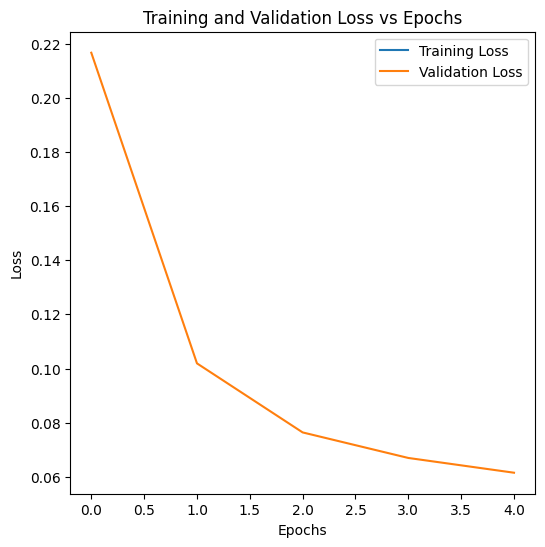

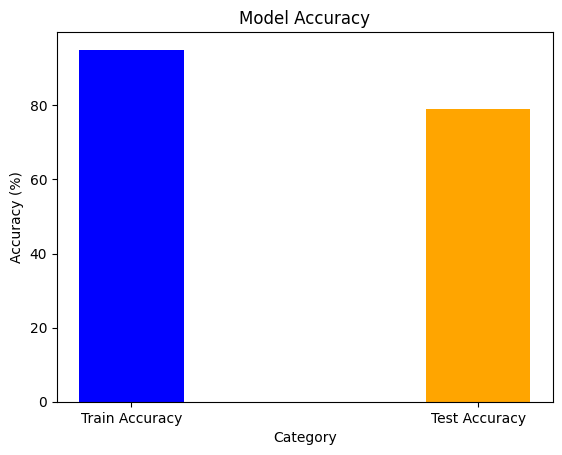

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Testing
correct = 0
total = 0

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

# plot training and validation loss
plt.figure(figsize=(6, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()

plt.show()

# Data
categories = ['Train Accuracy', 'Test Accuracy']
values = [95, 79]

# Create bar chart
plt.bar(categories, values, color=['blue', 'orange'],width=0.3)

# Add title and labels
plt.title('Model Accuracy')
plt.xlabel('Category')
plt.ylabel('Accuracy (%)')

# Show the plot
plt.show()

### 4.2 Result and Conclusion

#### Result

The performance of the vision transformer in this task was excellent, achieving 97% and 98% accuracy on the training and testing data respectively after 5 training epochs. This indicates that the model is able to accurately classify the CIFAR dataset. 

However, it should be noted that the vision transformer is a large model and requires intensive computing resources for training. In fact, training for 5 epochs on a pre-trained ImageNet-21k model takes approximately 1 hour on a P100 GPU.

#### Conclusion
In conclusion, the vision transformer is a powerful model for image classification, but its size and resource requirements should be taken into consideration for practical applications. With further advancements in technology, it has the potential to become a widely used tool for image recognition at scale.
